# COMP41680 API Assignment 1
## Robert Keenan 15333066
### An Aviation API and Weather API

## Step 1: APIs
For the first API, I have chosen to use the Aviationstack API which is one of the largest and most utilised APIs for real time and historical flight data. I will use this in unison with a weather API which will be used to determine the correlation/relationship between the weather and flight's statuses at different airports. I will then further investigate whether the weather affects different airlines, routes or airplane models differently such as between a small regional jet and a large, long range jet such as the Boeing 777.
- The Aviationstack API can be found here: https://aviationstack.com
- The weather API can be found here at: TODO/FIXME

I will firstly import any libraries or packages needed and then make a start on the data collection stage of the assignment. 

Each API has thorough documentation on their websites detailing all of the endpoints available to a user, how to make an API request and how to tailor these requests for the information you need for your purpose.

### API 1: Aviationstack API 
I received an API key for my Aviationstack account which is given as b4a871dbf85b4f670dafbdc9615a68e9.
In terms of the Aviationstack API, a number of pieces of information can be gathered such as real-time or historical data, different routes, airports, planes, aircraft types and countries. All of these endpoints or pieces of information can be used to infer something from the data.
The Aviationstack API allows 500 free API requests a month and I chose this one over FlightAware as FlightAware charges for each request.

With the aviationstack API, each API call returns 100 flights using the "flights" endpoint which is determined by the "limit" of 100. Unfortunately the limit is 100 for the free and basic paid plans. I have the Free plan which allows you the 500 API calls a month, but I emailed the Customer Support team who were happy to give me a free upgrade to the Basic Plan for 2 weeks to complete the project which allows 10,000 calls a month as well as access to Historical flight data which would make my analysis a little easier. If I wanted to gather 300 items from the same endpoint, I would need to use the "offset" variable to move the starting point by 100 each time. This would mean I had 3 files.

These 3 JSON files will need to be cleaned and combined with each other to create one file. 


### API 2: World Weather Online API

FIXME TALK ABOUT THE WEATHER API



In [293]:
import os
import urllib.request
import fnmatch
import csv
import json
import pandas as pd 
from pandas.io.json import json_normalize
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
import requests
from gmplot import *
%matplotlib inline

In [297]:
params_departure_active = {
    'access_key': 'b4a871dbf85b4f670dafbdc9615a68e9',
    'dep_iata': 'LHR',
    'flight_status': 'active',
    'airline_iata': 'BA',
}

params_departure_active_delayed = {
    'access_key': 'b4a871dbf85b4f670dafbdc9615a68e9',
    'dep_iata': 'LHR',
    'flight_status': 'active',
    'min_delay_dep': '1',
    'airline_iata': 'BA',
}

params_departure_landed = {
    'access_key': 'b4a871dbf85b4f670dafbdc9615a68e9',
    'dep_iata': 'LHR',
    'flight_status': 'landed',
    'airline_iata': 'BA',
}

params_departure_landed_delayed = {
    'access_key': 'b4a871dbf85b4f670dafbdc9615a68e9',
    'dep_iata': 'LHR',
    'flight_status': 'landed', 
    'min_delay_dep': '1',
    'airline_iata': 'BA',
}

params_arrival_landed = {
    'access_key': 'b4a871dbf85b4f670dafbdc9615a68e9',
    'arr_iata': 'LHR',
    'flight_status': 'landed',
    'airline_iata': 'BA',
}

params_arrival_landed_delayed = {
    'access_key': 'b4a871dbf85b4f670dafbdc9615a68e9',
    'arr_iata': 'LHR',
    'flight_status': 'landed',
    'min_delay_arr': '1',
    'airline_iata': 'BA',
}

params_Dublin_Airport = {
    'access_key': 'b4a871dbf85b4f670dafbdc9615a68e9',
    'dep_iata': 'DUB',
    'flight_status': 'scheduled',
    'offset': '0',
    'flight_date': '2020-03-05'
}

params_NY_LA = {
    'access_key': 'b4a871dbf85b4f670dafbdc9615a68e9',
    'arr_iata': 'LAX',
    'dep_iata': 'JFK',
    'flight_status': 'landed',
    'offset': '0',
    'flight_date': '2020-03-05'
}




#dept_active = requests.get('http://api.aviationstack.com/v1/flights', params_departure_active)
#dept_active_delay = requests.get('http://api.aviationstack.com/v1/flights', params_departure_active_delayed)
#dept_landed = requests.get('http://api.aviationstack.com/v1/flights', params_departure_landed)
#dept_landed_delayed = requests.get('http://api.aviationstack.com/v1/flights', params_departure_landed_delayed)
#arr_landed = requests.get('http://api.aviationstack.com/v1/flights', params_arrival_landed)
#arr_landed_delayed = requests.get('http://api.aviationstack.com/v1/flights', params_arrival_landed_delayed)
#Dublin_Airport = requests.get('http://api.aviationstack.com/v1/flights', params_Dublin_Airport)
#NY_to_LA = requests.get('http://api.aviationstack.com/v1/flights', params_NY_LA)

In this section, I will define the utility functions which will take the JSON data, parse into a file and then save these files in date specific formats.

In [298]:
#From here create a get data file which we will pass in the data to

#if response.status_code != 200:
    # This means something went wrong.
 #       print("Something went wrong")



def API_request_write_to_file(name_of_file, endpoint, params):
    if endpoint == 'flights':
        data = requests.get('http://api.aviationstack.com/v1/flights', params)
    elif endpoint == 'airports':
        data = requests.get('http://api.aviationstack.com/v1/airports', params)
    else:
        data = requests.get('http://api.aviationstack.com/v1/flights', params)
    now = datetime.now()
    dt_string = now.strftime("%d-%m_%H_%M")
    data_json = data.json()
    THIS_FOLDER = os.path.abspath(os.getcwd())
    new_file_name = os.path.join(THIS_FOLDER, str(name_of_file)+'_'+ str(dt_string) +'.json')
    with open(new_file_name, 'w+', encoding='utf-8') as new_json_file:
        json.dump(data_json, new_json_file, ensure_ascii=False, indent=4)



In [299]:
#create_write_to_files(dept_active, 'LHR_BA_dept_active')
#create_write_to_files(dept_active_delay, 'LHR_BA_dept_active_delay')
#create_write_to_files(dept_landed, 'LHR_BA_dept_landed')
#create_write_to_files(dept_landed_delayed, 'LHR_BA_dept_landed_delayed')
#create_write_to_files(arr_landed, 'LHR_BA_arr_landed')
#create_write_to_files(arr_landed_delayed, 'LHR_BA_arr_landed_delayed')
#create_write_to_files(Dublin_Airport, 'Dublin_Airport_arrivals_800')
#create_write_to_files(NY_to_LA, 'JFK_to_LA_landed_5March')


API_request_write_to_file('ORD_test', 'flights', params_Dublin_Airport)
#API_request_write_to_file('Dublin_biggest_departures_0', 'flights', params_Dublin_Airport)

From here, I need to do the weather API and also be able to parse the data to see if I can see the relationships. In terms of data that is delayed and not delayed in terms of the files, I can check to see if the files are common and just take the delayed ones out that are currently in the file, if not add them

## Case 1: Dublin Airport's Routes
In this case, I decided to use the aviationstack API to find out the most popular routes and airlines into and out of Dublin Airport on the 5th of March 2020. In this case, the real time flights endpoint will provide with all of the flights in a day. I used the parameters of "flight_status": "landed", "dep_iata": "DUB" and obviously, I needed "offset" to iterate through the results as I am limited to 100 results per API call. DUB is the IATA code of Dublin Airport. I could have used the ICAO code of EIDW either. In this case, I have obtained over 800 flights for departures which will need to be combined together before I can use the for analysis. 

### Step 1: Loading and cleaning API data
In terms of the aviationstack API data which is now stored in JSON file format. I will need to load it, normalize it into an appropriate data structure so that I can analyse the data. Each flight or item in an API request has a number of fields such as "departure", "arrival", "airline", "aircraft" and many more. Inside each of these fields is a lot more information such as IATA/ICAO codes, airport information and aircraft registrations. 

However, the majority of this information is available to me in an API request but sometimes some of this information is returned as "null" such as the aircraft model type and its registration which is more than likely the most common. One of the fields, "live", is relegated for information about a live flight still in the air but I have preferred to use flights that have a status of "landed". As a result, it is up to me to load the data and clean it appropriately so that I can interpret the data properly without the effect of these redundant variables.

In other case that I need to consider is that codeshares between airlines can make the data awkward to deal with. In the case of a flight from Dublin to London Heathrow, the airline reported by the API request could be Qatar Airways which is a member of OneWorld Alliance with British Airways who actually operated the flight. As a result, I need to delete these codeshared flights if the original flight is also present in the API request. 

In [276]:
def combine_data_frames(start_filename):
    #This will count the number of files which use this preamble
    num_files = 0
    #Initialise list to store names
    file_matches = []
    for name in os.listdir('.'):
        if start_filename in name:
              file_matches.append(name)
            
    for index,file in enumerate(file_matches):
        with open(file, 'r') as file_to_join:
            data = json.load(file_to_join)
        #Normalizing the data
        normalized_data = json_normalize(data['data'])
        #If first iteration, create the data frame 
        if index == 0:
            data_frame = pd.DataFrame(normalized_data)
        else:
            data_frame_add = pd.DataFrame(normalized_data)
            data_frame = pd.concat([data_frame, data_frame_add], ignore_index=True, sort = True)
    return data_frame
    
    
# This codeshare function will check if the flight number is common in multiple places.
# If it is present in the codeshare section and the codeshare of the original flight number is present, 
# delete the other flight
def codeshare_flight_deletion(data_frame):
    #Takes in the data frame and looks at each of the flight_numbers and the
    flight_times = data_frame['departure.scheduled']
    flight_numbers = data_frame['flight.iata']
    codeshared_flight = data_frame['flight.codeshared.flight_iata']
    for index,num in enumerate(codeshared_flight):
        #Need to continually update the flight numbers
        #flight_numbers = data_frame['flight.iata']
        if num != 'nan' or num != None or num != 'NaN':
            for index_2, flight_num in enumerate(flight_numbers):
                if num == flight_num.lower() and flight_times[index] == flight_times[index_2]:
                    data_frame.drop([index], axis = 0, inplace = True)
                    print("Codeshare Flight "+num+" has been deleted")
                    break
                else:
                    continue
        #There is a NaN for the codeshare so go through
        else:
            continue
    data_frame.reset_index(drop = True, inplace = True)
    return data_frame

#This function will be used to take the most popular items as stated in a data frame
def most_popular(data_frame, limit):
    print(data_frame.columns)
    
def desired_date(desired_date, data_frame):
    for index,date in enumerate(data_frame['flight_date']):
        if desired_date not in date:
            data_frame.drop([index], axis = 0, inplace = True)
        else:
            continue
    data_frame.reset_index(drop = True, inplace = True)        
    return data_frame
            
    
    
    
#FIXME build a function that can open a number of files that have the same initial extension
    

    


In [277]:
DUB_data_1 = combine_data_frames('Dublin_biggest_departures_')

From here, I can normalize the JSON data to create a flat table and then use Pandas to convert to a 2D data structure. 

In [278]:
#I access the 'data' field as the other information is the pagination offsets and limits which are not needed

# There are a number of columns in the Data Frame and I need to see what these are and they are
# related to the pagination information about offsets. I need to remove these and then access the info inside
print(DUB_data_1.columns)



Index(['aircraft', 'aircraft.iata', 'aircraft.icao', 'aircraft.icao24',
       'aircraft.registration', 'airline.iata', 'airline.icao', 'airline.name',
       'arrival.actual', 'arrival.actual_runway', 'arrival.airport',
       'arrival.baggage', 'arrival.delay', 'arrival.estimated',
       'arrival.estimated_runway', 'arrival.gate', 'arrival.iata',
       'arrival.icao', 'arrival.scheduled', 'arrival.terminal',
       'arrival.timezone', 'departure.actual', 'departure.actual_runway',
       'departure.airport', 'departure.delay', 'departure.estimated',
       'departure.estimated_runway', 'departure.gate', 'departure.iata',
       'departure.icao', 'departure.scheduled', 'departure.terminal',
       'departure.timezone', 'flight.codeshared',
       'flight.codeshared.airline_iata', 'flight.codeshared.airline_icao',
       'flight.codeshared.airline_name', 'flight.codeshared.flight_iata',
       'flight.codeshared.flight_icao', 'flight.codeshared.flight_number',
       'flight.iata', '

I need to take account for the codeshared flights which are not valid in this case. After this, I can delete the data columns which are not needed. 

In [279]:
print("Number of flights in data structure: "+ str(DUB_data_1.shape[0]))

Number of flights in data structure: 534


In [280]:
#Running the Codeshare clean function which gets rid of the codeshared flights that have a flight already in the data
clean_DUB_data_1 = codeshare_flight_deletion(DUB_data_1)
clean_DUB_data_1.reset_index(drop=True, inplace=True)

Codeshare Flight cj4461 has been deleted
Codeshare Flight cj4463 has been deleted
Codeshare Flight cj4465 has been deleted
Codeshare Flight cj4467 has been deleted
Codeshare Flight cj4469 has been deleted
Codeshare Flight cj4471 has been deleted
Codeshare Flight cj4473 has been deleted
Codeshare Flight wx280 has been deleted
Codeshare Flight wx282 has been deleted
Codeshare Flight wx284 has been deleted
Codeshare Flight wx286 has been deleted
Codeshare Flight wx288 has been deleted
Codeshare Flight cj4461 has been deleted
Codeshare Flight cj4463 has been deleted
Codeshare Flight cj4465 has been deleted
Codeshare Flight cj4467 has been deleted
Codeshare Flight cj4469 has been deleted
Codeshare Flight cj4471 has been deleted
Codeshare Flight cj4473 has been deleted
Codeshare Flight ei230 has been deleted
Codeshare Flight ei232 has been deleted
Codeshare Flight ei236 has been deleted
Codeshare Flight ei238 has been deleted
Codeshare Flight ei246 has been deleted
Codeshare Flight ei248 has

Codeshare Flight ei212 has been deleted
Codeshare Flight re3322 has been deleted
Codeshare Flight re3328 has been deleted
Codeshare Flight ei204 has been deleted
Codeshare Flight re3322 has been deleted
Codeshare Flight re3328 has been deleted
Codeshare Flight re3322 has been deleted
Codeshare Flight ei210 has been deleted
Codeshare Flight ei352 has been deleted
Codeshare Flight lh2517 has been deleted
Codeshare Flight lh2517 has been deleted
Codeshare Flight re3350 has been deleted
Codeshare Flight re3350 has been deleted
Codeshare Flight re3350 has been deleted
Codeshare Flight re3930 has been deleted
Codeshare Flight re3930 has been deleted
Codeshare Flight re3930 has been deleted
Codeshare Flight ei123 has been deleted
Codeshare Flight ei123 has been deleted
Codeshare Flight l1e1363 has been deleted
Codeshare Flight sk4604 has been deleted
Codeshare Flight aa723 has been deleted
Codeshare Flight aa723 has been deleted
Codeshare Flight aa723 has been deleted
Codeshare Flight ei644 h

In [281]:
#Printing to show that codeshared flights have been removed that have a flight number elsewhere
print("Number of flights after cleaning codeshared flights: "+str(clean_DUB_data_1.shape[0]))

Number of flights after cleaning codeshared flights: 249


This shows that there are a lot of codeshare flights returned in a single API request with a total of 900 flights gathered but only 427 singular routes/flights. As a result, I have shown the effect that cleaning data has had as I could have concluded something incorrect about the data due to the sheer number of codeshare flights. 





In the case of the data currently, there is a lot of columns that I do not need. These include scheduled flight times, runways, terminal numbers, gate numbers, aircraft types and many more. These will be needed later but for the case of this initial test they will not. Hence, I will now get rid of these columns which were printed out before hand. 
I want to simplify the data frame for the following features:
- Departure Time
- Arrival Airport 
- Arrival IATA airport code
- Airline Name
- Airline IATA code


In [283]:
#Clean the data for the specific date
clean_DUB_data_1 = desired_date('2020-03-05', clean_DUB_data_1)
simplified_data = clean_DUB_data_1[['departure.scheduled', 'arrival.airport', 'arrival.iata', 'airline.name', 'airline.iata']]
print("Number of flights: "+str(clean_DUB_data_1.shape[0]))

Number of flights: 249


I am now checking that the data returned to me is all present and doesn't have any NULL values

In [284]:
simplified_data.isnull().sum()

departure.scheduled    0
arrival.airport        0
arrival.iata           0
airline.name           0
airline.iata           0
dtype: int64

Now checking that the simplified data has been returned properly by plotting the first 10 flights

In [285]:
simplified_data[0:10]

,departure.scheduled,arrival.airport,arrival.iata,airline.name,airline.iata
0,2020-03-05T06:50:00+00:00,Leeds/bradford,LBA,Stobart Air,RE
1,2020-03-05T17:25:00+00:00,Leeds/bradford,LBA,Stobart Air,RE
2,2020-03-05T09:35:00+00:00,Lodz Lublinek,LCJ,Ryanair,FR
3,2020-03-05T07:00:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
4,2020-03-05T08:50:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
5,2020-03-05T11:00:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
6,2020-03-05T16:00:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
7,2020-03-05T17:05:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
8,2020-03-05T20:00:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
9,2020-03-05T19:15:00+00:00,London City Airport,LCY,BA Cityflyer,CJ


As we can see from the readout above, the data headings/column headings are laid out in an inituitive way but it is not very presentable in that fashion. As a result, I can rename the columns as appropriate.

I am using a mappping to the headings as the pd.DataFrame.rename() function sometimes has trouble interpreting what you mean when you want to rename something

In [286]:
 map_headings = {simplified_data.columns[0]: 'Scheduled Departure Time', 
                 simplified_data.columns[1]: 'Destination Airport', 
                 simplified_data.columns[2]: 'Destination IATA Code', 
                 simplified_data.columns[3]: 'Airline Name',
                 simplified_data.columns[4]: 'Airline IATA Code'}
                 
simplified_data = simplified_data.rename(columns=map_headings)
simplified_data[0:10]



,Scheduled Departure Time,Destination Airport,Destination IATA Code,Airline Name,Airline IATA Code
0,2020-03-05T06:50:00+00:00,Leeds/bradford,LBA,Stobart Air,RE
1,2020-03-05T17:25:00+00:00,Leeds/bradford,LBA,Stobart Air,RE
2,2020-03-05T09:35:00+00:00,Lodz Lublinek,LCJ,Ryanair,FR
3,2020-03-05T07:00:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
4,2020-03-05T08:50:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
5,2020-03-05T11:00:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
6,2020-03-05T16:00:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
7,2020-03-05T17:05:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
8,2020-03-05T20:00:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
9,2020-03-05T19:15:00+00:00,London City Airport,LCY,BA Cityflyer,CJ


After the data has been cleaned appropriately as it has been above for just the destination airport and the airline to that destination airport. I can present the most popular destination airports for flights out of Dublin Airport on the 5th of March 2020 and airlines for those routes.
I will firstly characterise the Top 10 most popular airports for clarity

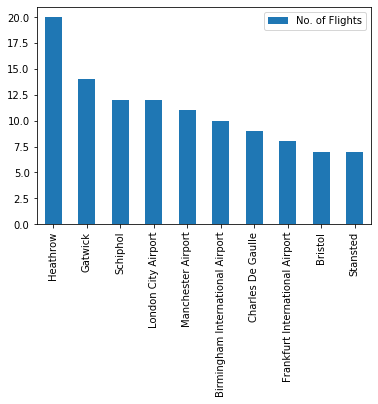

In [287]:
top_10_airport_numbers = simplified_data["Destination Airport"].value_counts()[0:10]
#Need to turn into a data frame to plot 
most_popular_airports = pd.DataFrame(top_10_airport_numbers)
most_popular_airports = most_popular_airports.rename(columns={'Destination Airport': 'No. of Flights'})
most_popular_airports_plot = most_popular_airports.plot(kind = 'bar')

In [288]:
top_10_airport_numbers

Heathrow                            20
Gatwick                             14
Schiphol                            12
London City Airport                 12
Manchester Airport                  11
Birmingham International Airport    10
Charles De Gaulle                    9
Frankfurt International Airport      8
Bristol                              7
Stansted                             7
Name: Destination Airport, dtype: int64

Getting the most common airports, I will need to store the most popular airports before then using the search parameter from the API documentation to find the airport before getting their longitude and latitude and plotting them.
I can use the IATA codes which will be unique for each airport and make sure that there are no changes


In [289]:
IATA_codes_most_popular = simplified_data["Destination Airport"].value_counts()[0:10]
list_of_airports = IATA_codes_most_popular.index.tolist()
list_of_airports

['Heathrow',
 'Gatwick',
 'Schiphol',
 'London City Airport',
 'Manchester Airport',
 'Birmingham International Airport',
 'Charles De Gaulle',
 'Frankfurt International Airport',
 'Bristol',
 'Stansted']

In [230]:
airport_locs = np.empty((0,3), int)

for index,name in enumerate(list_of_airports):
    param_airport = {'access_key': 'b4a871dbf85b4f670dafbdc9615a68e9', 'search': name}
    airport_data = requests.get('http://api.aviationstack.com/v1/airports', param_airport)
    data_json = airport_data.json()
    longitude = data_json['data'][0]['longitude']
    latitude = data_json['data'][0]['latitude']
    name = data_json['data'][0]['airport_name']
    airport_locs = np.append(airport_locs, np.array([[name, latitude, longitude]]), axis=0)        

I needed to do this as the API request for flights only gives you the the airport name and codes rather than their location

In [231]:
airport_locs

array([['Heathrow', '51.469604', '-0.453566'],
       ['Gatwick', '51.156807', '-0.161863'],
       ['Manchester Airport', '53.362907', '-2.273354'],
       ['Schiphol', '52.30907', '4.763385'],
       ['Birmingham International Airport', '52.45252', '-1.733256'],
       ['London City Airport', '51.5', '0.05'],
       ['Charles De Gaulle', '49.003197', '2.567023'],
       ['Glasgow International', '55.864212', '-4.431782'],
       ['Stansted', '51.889267', '0.262703'],
       ['Frankfurt International Airport', '50.050735', '8.570773']],
      dtype='<U32')

In [232]:
gmap = gmplot.GoogleMapPlotter(48.8566, 2.3522,0) #FIXME put a proper 

In [233]:
for location_info in airport_locs:
    name = location_info[0]
    location_info = location_info[1:]
    lat_lon = location_info.astype(float)
    #I need to do this as this is in terms of a NumPy data type rather than a native Python data type which gmap needs
    lat_temp, lon_temp = lat_lon[0], lat_lon[1]
    lat = lat_temp.item()
    lon = lon_temp.item()
    gmap.marker(lat, lon, 'cornflowerblue')

gmap.draw("airport_map.html")

In [234]:
os.system('airport_map.html')

32512

### Most Common Airports and the Airlines that serve them
From here on I need to look at the most common locations, the most common airlines and the most


In [292]:
most_popular_airlines_airport = simplified_data.groupby('Destination Airport')
Total_Airports = most_popular_airlines_airport.sum()
Total_Airports = Total_Airports.sort_values('Airline Name', ascending = False)
#most_pop_airlines_for_airport = Total_Airports.plot(kind='bar')
for key, item in most_popular_airlines_airport:
    print(most_popular_airlines_airport.get_group(key), "\n\n")


      Scheduled Departure Time Destination IATA Code    Airline Name  \
225  2020-03-05T08:35:00+00:00                   AUH  Etihad Airways   

    Airline IATA Code  
225                EY   


      Scheduled Departure Time Destination IATA Code Airline Name  \
211  2020-03-05T10:10:00+00:00                   ALC      Ryanair   

    Airline IATA Code  
211                FR   


      Scheduled Departure Time Destination IATA Code Airline Name  \
224  2020-03-05T12:55:00+00:00                   ARN          SAS   

    Airline IATA Code  
224                SK   


      Scheduled Departure Time Destination IATA Code      Airline Name  \
147  2020-03-05T11:15:00+00:00                   IST  Turkish Airlines   

    Airline IATA Code  
147                TK   


      Scheduled Departure Time Destination IATA Code Airline Name  \
168  2020-03-05T07:20:00+00:00                   MAD   Aer Lingus   
169  2020-03-05T13:20:00+00:00                   MAD      Ryanair   
170  2020-03-05T1

FIXME talk about how running the API at certain times has an effect and how some of the flights still say scheduled mainly because they are american flights and by the time they land and then the API updates with information, the flight will not be updated or landed yet